## Gill响应-热源动态

In [15]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.linalg import inv
import os
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

# Create output directory for frames
if not os.path.exists('gill_frames'):
    os.makedirs('gill_frames')

# All constants
N = 128
x1, x2 = -16, 16
Lx = x2 - x1
y1, y2 = -8, 8
Ly = y2 - y1
epi1 = 0.1

# Create meshgrid
xx = np.linspace(x1, x2, N)
yy = np.linspace(y2, y1, N)
x, y = np.meshgrid(xx, yy)
y2_op = y ** 2  # create y^2 operator
dx = Lx / (N - 1)
dy = Ly / (N - 1)
Q0 = 0.5

# Convert grid to latitude and longitude
# Map the x coordinates to longitude (from -180° to 180°)
# Map the y coordinates to latitude (from -90° to 90°)
lon = x * (180 / 16)  # Scale x to longitude range
lat = y * (90 / 8)    # Scale y to latitude range

# Time parameters
total_time = 40.0  # total simulation time
num_frames = 80    # number of frames to generate
dt = total_time / num_frames  # time step

# Create first and second order differentials of y
diff_y = np.zeros((N, N))
diff_yy = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i == j + 1:
            diff_y[i, j] = (0.5 + diff_y[i, j]) / dy
            diff_yy[i, j] = (1 + diff_yy[i, j]) / dy ** 2
        elif i == j - 1:
            diff_y[i, j] = (-0.5 + diff_y[i, j]) / dy
            diff_yy[i, j] = (1 + diff_yy[i, j]) / dy ** 2
        elif i == j:
            diff_y[i, j] /= dy
            diff_yy[i, j] = (-2 + diff_yy[i, j]) / dy ** 2

# Create wave number matrix
k = np.zeros(N)
for j in range(N):
    if j <= N / 2:
        k[j] = (j) * 2 * np.pi / Lx
    elif j > N / 2 + 1:
        k[j] = -(N - j) * 2 * np.pi / Lx

# Initialize arrays to store time-dependent fields
U_frames = []
V_frames = []
Q_frames = []

# Create colormap for heat source
heat_cmap = plt.get_cmap('Blues')
wind_speed_cmap = plt.get_cmap('bwr')

# Time evolution loop
for frame in range(num_frames):
    t = frame * dt
    
    # Time-dependent heat source
    # Here we'll make the heat source oscillate and move with time
    Q = np.zeros((N, N))
    epi2 = np.ones((N, N)) * epi1
    
    # Heat source parameters that change with time
    x_center = 4 + 2 * np.sin(t)  # Center oscillates horizontally
    y_amplitude = 1 + 0.5 * np.sin(2*t)  # Amplitude oscillates
    width = 8 + 2 * np.sin(0.5*t)  # Width oscillates
    
    # Prescribed heat source with time dependence
    for i in range(N):
        for j in range(N):
            # Oscillating heat source
            if 0 <= xx[j] <= width and -4 <= yy[i] <= 4:
                Q[i, j] = Q0 * np.cos(np.pi * (xx[j] - x_center) / width) * np.exp(-(yy[i])**2 / (2*y_amplitude)**2)
    
    # FFT of Q
    ImQ = np.zeros((N, N), dtype=complex)
    for i in range(N):
        ImQ[i, :] = fft(Q[i, :], N)
    
    # Matrix operations from Zebiak 1982
    ImV = np.zeros((N, N), dtype=complex)
    
    for j in range(N):
        A = diff_yy + ((-0.25) * y2_op + (-1) ** 0.5 / (2 * epi1) * k[j] - epi1 ** 2 + k[j] ** 2) * np.eye(N)
        B = -diff_y @ ImQ[:, j] + (-1) ** 0.5 / (2 * epi1) * k[j] * y[:, j] * ImQ[:, j]
        ImV[:, j] = inv(A) @ B
    
    # Calculation of ImU
    ImU = np.zeros((N, N), dtype=complex)
    for j in range(N):
        if abs(k[j]) < 1e-10:  # Handle the k=0 case separately to avoid division by zero
            ImU[:, j] = 0
        else:
            A1 = 0.5 * epi1 * y
            A2 = (-1) ** 0.5 * k[j] * diff_y
            B = (-1) ** 0.5 * k[j]
            ImU[:, j] = (A1[:, j] * ImV[:, j] + A2 @ ImV[:, j] + B * ImQ[:, j]) / (k[j] ** 2 + epi1 ** 2)
    
    # Inverse FFT to get U and V
    V = np.zeros((N, N), dtype=complex)
    for i in range(N):
        V[i, :] = ifft(ImV[i, :], N)
    
    U = np.zeros((N, N), dtype=complex)
    for i in range(N):
        U[i, :] = ifft(ImU[i, :], N)
    
    # Store the fields for this time step
    U_frames.append(np.real(U))
    V_frames.append(np.real(V))
    Q_frames.append(Q)
    
    # Calculate wind speed for coloring
    wind_speed = np.sqrt(np.real(U)**2 + np.real(V)**2)
    
    # Plot and save each frame with a nicer layout using cartopy
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(f'Gill Model Response - Day {int(t*10)}', fontsize=20, y=0.98)
    
    # Use GridSpec for better control over the layout
    gs = gridspec.GridSpec(1, 1, figure=fig)
    
    # Create a single plot with both heat source and wind field
    ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
    
    # Add map features
    ax.coastlines(resolution='110m', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Add equator line
    ax.plot([-180, 180], [0, 0], 'k--', linewidth=0.8, alpha=0.5, transform=ccrs.PlateCarree())
    
    # Plot heat source as filled contours
    heat_levels = np.linspace(0, Q0, 21)
    heat_contour = ax.contourf(lon, lat, Q, levels=heat_levels, cmap=heat_cmap, 
                           transform=ccrs.PlateCarree(), 
                           extend='neither', 
                           alpha=0.7)
    
    # Add heat source colorbar
    cbar_heat = plt.colorbar(heat_contour, ax=ax, orientation='horizontal', 
                         pad=0.05, aspect=40, shrink=0.8, label='Heat Source Intensity')
    
    # Plot wind vectors with variable color based on wind speed
    skip = 4  # Skip every nth point for clarity
    quiver = ax.quiver(lon[::skip, ::skip], lat[::skip, ::skip], 
                   np.real(U[::skip, ::skip]), np.real(V[::skip, ::skip]),
                   wind_speed[::skip, ::skip], 
                color='white', scale=15, width=0.002,
                   pivot='mid', transform=ccrs.PlateCarree(),)
    
    # Add wind speed colorbar
    cbar_wind = plt.colorbar(quiver, ax=ax, orientation='vertical', 
                         pad=0.05, aspect=40, shrink=0.6, label='Wind Speed')
    
    # Set plot limits to show the relevant region
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    
    # Add title and labels
    ax.set_title(f'Heat Source and Wind Field Response', fontsize=14)
    
    # Add day counter in the corner
    time_text = ax.text(0.02, 0.96, f'Day {int(t*10)}', transform=ax.transAxes,
                    fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Save frame with high quality
    plt.tight_layout()
    plt.savefig(f'gill_frames/frame_{frame:03d}.png', dpi=200, bbox_inches='tight')
    plt.close()
    
    print(f"Processed frame {frame+1}/{num_frames}")

print("All frames saved to 'gill_frames' directory")


Processed frame 1/80
Processed frame 2/80
Processed frame 3/80
Processed frame 4/80
Processed frame 5/80
Processed frame 6/80
Processed frame 7/80
Processed frame 8/80
Processed frame 9/80
Processed frame 10/80
Processed frame 11/80
Processed frame 12/80
Processed frame 13/80
Processed frame 14/80
Processed frame 15/80
Processed frame 16/80
Processed frame 17/80
Processed frame 18/80
Processed frame 19/80
Processed frame 20/80
Processed frame 21/80
Processed frame 22/80
Processed frame 23/80
Processed frame 24/80
Processed frame 25/80
Processed frame 26/80
Processed frame 27/80
Processed frame 28/80
Processed frame 29/80
Processed frame 30/80
Processed frame 31/80
Processed frame 32/80
Processed frame 33/80
Processed frame 34/80
Processed frame 35/80
Processed frame 36/80
Processed frame 37/80
Processed frame 38/80
Processed frame 39/80
Processed frame 40/80
Processed frame 41/80
Processed frame 42/80
Processed frame 43/80
Processed frame 44/80
Processed frame 45/80
Processed frame 46/

Animation saved as 'gill_model_animation.gif'


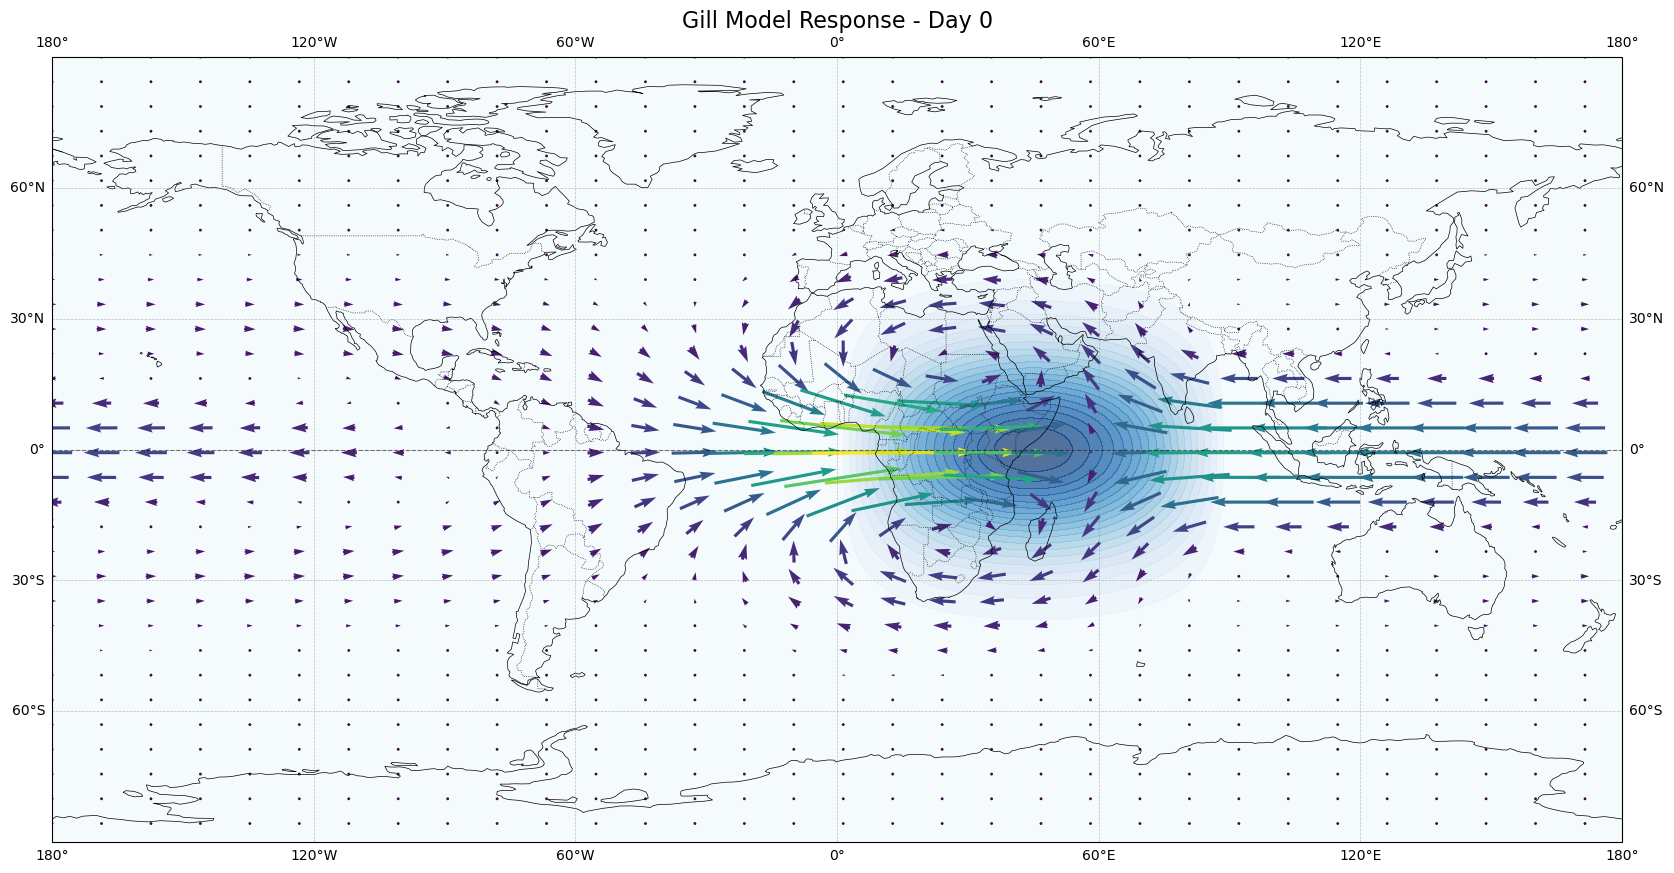

In [16]:
# Create animated GIF using matplotlib
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

def update(frame):
    ax.clear()
    
    # Add map features
    ax.coastlines(resolution='110m', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Add equator line
    ax.plot([-180, 180], [0, 0], 'k--', linewidth=0.8, alpha=0.5, transform=ccrs.PlateCarree())
    
    # Plot heat source
    heat_levels = np.linspace(0, Q0, 21)
    heat_contour = ax.contourf(lon, lat, Q_frames[frame], levels=heat_levels, 
                           cmap=heat_cmap, transform=ccrs.PlateCarree(), 
                           extend='neither', alpha=0.7)
    
    # Calculate wind speed for this frame
    wind_speed = np.sqrt(np.real(U_frames[frame])**2 + np.real(V_frames[frame])**2)
    
    # Plot wind vectors
    skip = 4
    quiver = ax.quiver(lon[::skip, ::skip], lat[::skip, ::skip], 
                   np.real(U_frames[frame][::skip, ::skip]), 
                   np.real(V_frames[frame][::skip, ::skip]),
                   wind_speed[::skip, ::skip],
                   transform=ccrs.PlateCarree(),
                   color='white', scale=15, width=0.002,
                   pivot='mid')
    
    # Set plot limits
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    
    # Add title
    ax.set_title(f'Gill Model Response - Day {int(frame*dt*10)}', fontsize=16)
    
    return [quiver]  # Return the artists that need to be updated

# Create animation
ani = FuncAnimation(fig, update, frames=num_frames, interval=3000, blit=False)

# Save with higher quality
plt.tight_layout()
ani.save('gill_model_animation.gif', writer='pillow', fps=1, dpi=100)

print("Animation saved as 'gill_model_animation.gif'")

### 添加速度、流函数、扰动气压

In [17]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.linalg import inv
import os
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import imageio
# Create output directory for frames
output_dir_gill = 'gill_frames_stream'
if not os.path.exists(output_dir_gill):
    os.makedirs(output_dir_gill)


# All constants
N = 128
x1, x2 = -16, 16
Lx = x2 - x1
y1, y2 = -8, 8
Ly = y2 - y1
epi1 = 0.1

# Create meshgrid
xx = np.linspace(x1, x2, N)
yy = np.linspace(y2, y1, N)
x, y = np.meshgrid(xx, yy)
y2_op = y ** 2  # create y^2 operator
dx = Lx / (N - 1)
dy = Ly / (N - 1)
Q0 = 0.5

# Convert grid to latitude and longitude
lon = x * (180 / 16)  # Scale x to longitude range
lat = y * (90 / 8)   # Scale y to latitude range

# Time parameters
total_time = 40.0  # total simulation time
num_frames = 80    # number of frames to generate
dt = total_time / num_frames  # time step

# Create first and second order differentials of y
diff_y = np.zeros((N, N))
diff_yy = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i == j + 1:
            diff_y[i, j] = (0.5 + diff_y[i, j]) / dy
            diff_yy[i, j] = (1 + diff_yy[i, j]) / dy ** 2
        elif i == j - 1:
            diff_y[i, j] = (-0.5 + diff_y[i, j]) / dy
            diff_yy[i, j] = (1 + diff_yy[i, j]) / dy ** 2
        elif i == j:
            diff_y[i, j] /= dy
            diff_yy[i, j] = (-2 + diff_yy[i, j]) / dy ** 2

# Create wave number matrix
k = np.zeros(N)
for j in range(N):
    if j <= N / 2:
        k[j] = (j) * 2 * np.pi / Lx
    elif j > N / 2 + 1:
        k[j] = -(N - j) * 2 * np.pi / Lx

# Initialize arrays to store time-dependent fields
U_frames = []
V_frames = []
Q_frames = []
P_frames = []  # Store perturbation pressure
PSI_frames = [] # Store stream function
u_max_positions = []  # For tracking Kelvin wave

# Create colormap for heat source
heat_cmap = plt.get_cmap('Blues')
wind_speed_cmap = plt.get_cmap('bwr')

# Time evolution loop
for frame in range(num_frames):
    t = frame * dt
    
    # Time-dependent heat source
    Q = np.zeros((N, N))
    epi2 = np.ones((N, N)) * epi1
    
    # Heat source parameters that change with time
    x_center = 4 + 2 * np.sin(t)  # Center oscillates horizontally
    y_amplitude = 1 + 0.5 * np.sin(2*t)  # Amplitude oscillates
    width = 8 + 2 * np.sin(0.5*t)  # Width oscillates
    
    # Prescribed heat source with time dependence
    for i in range(N):
        for j in range(N):
            if 0 <= xx[j] <= width and -4 <= yy[i] <= 4:
                Q[i, j] = Q0 * np.cos(np.pi * (xx[j] - x_center) / width) * np.exp(-(yy[i])**2 / (2*y_amplitude)**2)
    
    # FFT of Q
    ImQ = np.zeros((N, N), dtype=complex)
    for i in range(N):
        ImQ[i, :] = fft(Q[i, :], N)
    
    # Matrix operations from Zebiak 1982
    ImV = np.zeros((N, N), dtype=complex)
    
    for j in range(N):
        A = diff_yy + ((-0.25) * y2_op + (-1) ** 0.5 / (2 * epi1) * k[j] - epi1 ** 2 + k[j] ** 2) * np.eye(N)
        B = -diff_y @ ImQ[:, j] + (-1) ** 0.5 / (2 * epi1) * k[j] * y[:, j] * ImQ[:, j]
        ImV[:, j] = inv(A) @ B
    
    # Calculation of ImU
    ImU = np.zeros((N, N), dtype=complex)
    for j in range(N):
        if abs(k[j]) < 1e-10:  # Handle the k=0 case separately
            ImU[:, j] = 0
        else:
            A1 = 0.5 * epi1 * y
            A2 = (-1) ** 0.5 * k[j] * diff_y
            B = (-1) ** 0.5 * k[j]
            ImU[:, j] = (A1[:, j] * ImV[:, j] + A2 @ ImV[:, j] + B * ImQ[:, j]) / (k[j] ** 2 + epi1 ** 2)
    
    # Inverse FFT to get U and V
    V = np.zeros((N, N), dtype=complex)
    for i in range(N):
        V[i, :] = ifft(ImV[i, :], N)
    
    U = np.zeros((N, N), dtype=complex)
    for i in range(N):
        U[i, :] = ifft(ImU[i, :], N)
    
    # Calculate stream function
    psi = np.zeros_like(U, dtype=float)
    for i in range(1, N):
        psi[i, :] = psi[i-1, :] - np.real(U)[i, :] * dy  # Integrate u along y
    for j in range(1, N):
        psi[:, j] = psi[:, j-1] + np.real(V)[:, j] * dx  # Integrate v along x
    
    # Calculate perturbation pressure (assuming Q and R are the same as ImQ and ImU for now)
    P = 0.5 * (ImQ + ImU)  # Calculate P in frequency space
    p = np.real(ifft(P, axis=1)).astype(float)
    
    # Store the fields for this time step
    U_frames.append(np.real(U))
    V_frames.append(np.real(V))
    Q_frames.append(Q)
    P_frames.append(p)
    PSI_frames.append(psi)
    
    # Calculate wind speed for coloring
    wind_speed = np.sqrt(np.real(U)**2 + np.real(V)**2).astype(float)
    
    # Track Kelvin wave (eastward propagation)
    u_max_x_index = np.argmax(np.max(np.real(U), axis=0))  # X-index of max U
    u_max_positions.append(xx[u_max_x_index])
    
    # Plot and save each frame with a nicer layout using cartopy
    fig, axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(f'Gill Model Response - Day {int(t*10)}', fontsize=20, y=0.95)
    
    # Add map features to all subplots
    for ax in axs.flat:
        ax.coastlines(resolution='110m', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
        ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        ax.plot([-180, 180], [0, 0], 'k--', linewidth=0.8, alpha=0.5, transform=ccrs.PlateCarree())
        ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    
    # Heat Source and Wind
    ax0 = axs[0, 0]
    heat_levels = np.linspace(0, Q0, 21)
    heat_contour = ax0.contourf(lon, lat, Q, levels=heat_levels, cmap=heat_cmap, transform=ccrs.PlateCarree(), extend='neither', alpha=0.7)
    cbar_heat = plt.colorbar(heat_contour, ax=ax0, orientation='horizontal', pad=0.05, aspect=40, shrink=0.8, label='Heat Source Intensity')
    skip = 4
    quiver = ax0.quiver(lon[::skip, ::skip], lat[::skip, ::skip], np.real(U[::skip, ::skip]), np.real(V[::skip, ::skip]), wind_speed[::skip, ::skip], color='white', scale=15, width=0.002, pivot='mid', transform=ccrs.PlateCarree())
    cbar_wind = plt.colorbar(quiver, ax=ax0, orientation='vertical', pad=0.05, aspect=40, shrink=0.6, label='Wind Speed')
    ax0.set_title('Heat Source and Wind Field', fontsize=14)
    
    # Stream function
    ax1 = axs[0, 1]
    contour_levels = np.linspace(-np.max(np.abs(psi)), np.max(np.abs(psi)), 21)
    stream_contour = ax1.contourf(lon, lat, psi, levels=contour_levels, cmap='RdBu', transform=ccrs.PlateCarree(), extend='both', alpha=0.7)
    cbar_stream = plt.colorbar(stream_contour, ax=ax1, orientation='horizontal', pad=0.05, aspect=40, shrink=0.8, label='Stream Function')
    ax1.set_title('Stream Function', fontsize=14)
    
    # Perturbation pressure
    ax2 = axs[1, 0]
    p_levels = np.linspace(-np.max(np.abs(p)), np.max(np.abs(p)), 21)
    p_contour = ax2.contourf(lon, lat, p, levels=p_levels, cmap='RdBu', transform=ccrs.PlateCarree(), extend='both', alpha=0.7)
    cbar_p = plt.colorbar(p_contour, ax=ax2, orientation='horizontal', pad=0.05, aspect=40, shrink=0.8, label='Perturbation Pressure')
    ax2.set_title('Perturbation Pressure', fontsize=14)
    
    # Eastward propagation speed
    ax3 = axs[1, 1]
    time_so_far = np.arange(0, (frame + 1) * dt, dt)
    if len(u_max_positions) >= 2:  # Only fit if we have at least two points
        coefficients = np.polyfit(time_so_far, u_max_positions, 1)
        average_eastward_speed = coefficients[0]
        ax3.plot(time_so_far, time_so_far * average_eastward_speed, label=f'Linear Fit (Speed: {average_eastward_speed:.2f})')
    ax3.plot(time_so_far, u_max_positions, 'o', label='Max U Position')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Longitude of Max U')
    ax3.set_title('Eastward Propagation', fontsize=12)
    ax3.legend()

    
    # Add day counter
    time_text = fig.text(0.02, 0.96, f'Day {int(t*10)}', fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'{output_dir_gill}/frame_{frame:03d}.png', dpi=200, bbox_inches='tight')
    plt.close()
    
    print(f"Processed frame {frame+1}/{num_frames}")

print("All frames saved to 'gill_frames' directory")

Processed frame 1/80
Processed frame 2/80
Processed frame 3/80
Processed frame 4/80
Processed frame 5/80
Processed frame 6/80
Processed frame 7/80
Processed frame 8/80
Processed frame 9/80
Processed frame 10/80
Processed frame 11/80
Processed frame 12/80
Processed frame 13/80
Processed frame 14/80
Processed frame 15/80
Processed frame 16/80
Processed frame 17/80
Processed frame 18/80
Processed frame 19/80
Processed frame 20/80
Processed frame 21/80
Processed frame 22/80
Processed frame 23/80
Processed frame 24/80
Processed frame 25/80
Processed frame 26/80
Processed frame 27/80
Processed frame 28/80
Processed frame 29/80
Processed frame 30/80
Processed frame 31/80
Processed frame 32/80
Processed frame 33/80
Processed frame 34/80
Processed frame 35/80
Processed frame 36/80
Processed frame 37/80
Processed frame 38/80
Processed frame 39/80
Processed frame 40/80
Processed frame 41/80
Processed frame 42/80
Processed frame 43/80
Processed frame 44/80
Processed frame 45/80
Processed frame 46/

In [21]:
import PIL

image=[]
mon=np.arange(1,80)#图片的个数
for i in mon:
    new=PIL.Image.open('gill_frames_stream/frame_%03d.png'%i)
    image.append(new)
image[0].save('gill_frames_stream.gif',format='GIF',
     append_images=image[1:],
     save_all=True,duration=1000,
     loop=0)#相关参数设置可以网络搜索一下，duration是间隔速率
print('gif绘制完成')


gif绘制完成
